In [35]:
import pandas as pd

In [36]:
df = pd.read_csv("outputs/results/lr/pythia410m/counterfact.csv")

In [37]:
df["lnum"] = df["parameter"].apply(lambda param: int(param.split(".")[2]))
df["lname"] = df["parameter"].apply(lambda param: param.split(".")[3] + "." + param.split(".")[4])

In [38]:
#df = df.sort_values("lname")
df = df.sort_values("lnum")
df.head()

,original_loss,original_top1_accuracy,original_top10_accuracy,original_top1_words,original_top10_words,parameter,dataset_len,rate,learning_rate,es,...,edited_top1_categories,edited_top10_categories,epoch_losses,final_loss,final_top1_accuracy,final_top10_accuracy,finally_top1_categories,final_top10_categories,lnum,lname
0,0.104498,0.080064,0.29486,"{'common_nouns': 173, 'proper_nouns': 11996, '...","{'common_nouns': 4088, 'proper_nouns': 109635,...",gpt_neox.layers.0.mlp.dense_4h_to_h.weight,65757,0.9,0.0001,3,...,"{'common_nouns': 1031, 'proper_nouns': 6698, '...","{'common_nouns': 7717, 'proper_nouns': 81442, ...","[0.04684262612150243, 0.042048916039385646, 0....",0.011993,0.839895,0.959837,"{'common_nouns': 3040, 'proper_nouns': 53796, ...","{'common_nouns': 34142, 'proper_nouns': 528531...",0,mlp.dense_4h_to_h
59,0.104498,0.080064,0.29486,"{'common_nouns': 173, 'proper_nouns': 11996, '...","{'common_nouns': 4088, 'proper_nouns': 109635,...",gpt_neox.layers.0.mlp.dense_h_to_4h.weight,65757,0.9,0.0001,3,...,"{'common_nouns': 962, 'proper_nouns': 6577, 'v...","{'common_nouns': 9653, 'proper_nouns': 76748, ...","[0.04714988095916971, 0.041579420549156025, 0....",0.010099,0.873413,0.967121,"{'common_nouns': 3032, 'proper_nouns': 54092, ...","{'common_nouns': 33807, 'proper_nouns': 528661...",0,mlp.dense_h_to_4h
58,0.104498,0.080064,0.29486,"{'common_nouns': 173, 'proper_nouns': 11996, '...","{'common_nouns': 4088, 'proper_nouns': 109635,...",gpt_neox.layers.0.attention.query_key_value.we...,65757,0.9,0.0001,3,...,"{'common_nouns': 147, 'proper_nouns': 12023, '...","{'common_nouns': 4142, 'proper_nouns': 109494,...","[0.04060263529311131, 0.03799037515682026, 0.0...",0.013731,0.814514,0.948888,"{'common_nouns': 3033, 'proper_nouns': 53880, ...","{'common_nouns': 33024, 'proper_nouns': 529465...",0,attention.query_key_value
57,0.104498,0.080064,0.29486,"{'common_nouns': 173, 'proper_nouns': 11996, '...","{'common_nouns': 4088, 'proper_nouns': 109635,...",gpt_neox.layers.0.attention.dense.weight,65757,0.9,0.0001,3,...,"{'common_nouns': 180, 'proper_nouns': 11975, '...","{'common_nouns': 4245, 'proper_nouns': 109182,...","[0.047949872167731146, 0.041704906454341543, 0...",0.024028,0.656675,0.889837,"{'common_nouns': 3086, 'proper_nouns': 53619, ...","{'common_nouns': 31330, 'proper_nouns': 532068...",0,attention.dense
2,0.104498,0.080064,0.29486,"{'common_nouns': 173, 'proper_nouns': 11996, '...","{'common_nouns': 4088, 'proper_nouns': 109635,...",gpt_neox.layers.0.attention.dense.weight,65757,0.8,0.0001,3,...,"{'common_nouns': 175, 'proper_nouns': 12020, '...","{'common_nouns': 4373, 'proper_nouns': 109077,...","[0.04420823888477038, 0.03921961726353406, 0.0...",0.020159,0.716699,0.913150,"{'common_nouns': 3048, 'proper_nouns': 53720, ...","{'common_nouns': 32847, 'proper_nouns': 529174...",0,attention.dense


In [85]:
df["accuracy_diff"] = df["edited_top1_accuracy"] - df["final_top1_accuracy"]

In [44]:
"""
print("0.9")
for i in range(len(df)):
    if df.iloc[i, 7] == 0.9:
        print(df.iloc[i, 5])

print("===============\n0.8")
for i in range(len(df)):
    if df.iloc[i, 7] == 0.8:
        print(df.iloc[i, 5])
"""

'\nprint("0.9")\nfor i in range(len(df)):\n    if df.iloc[i, 7] == 0.9:\n        print(df.iloc[i, 5])\n\nprint("===============\n0.8")\nfor i in range(len(df)):\n    if df.iloc[i, 7] == 0.8:\n        print(df.iloc[i, 5])\n'

Missing:

======================
0.8

block 1     21 22 23

block 2     16 17 18 19 20 21 22 23

block3      all

block 4     all


======================
0.9

block 1     23

block 2     15 16 17 18 19 20 21 22 23

block3      14 20 21 22 23

block 4     20 21 22 23



In [49]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [87]:
df8 = df[df["rate"] == 0.8]
df9 = df[df["rate"] == 0.9]

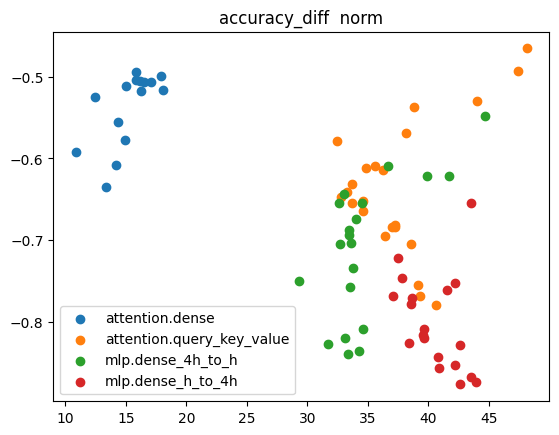

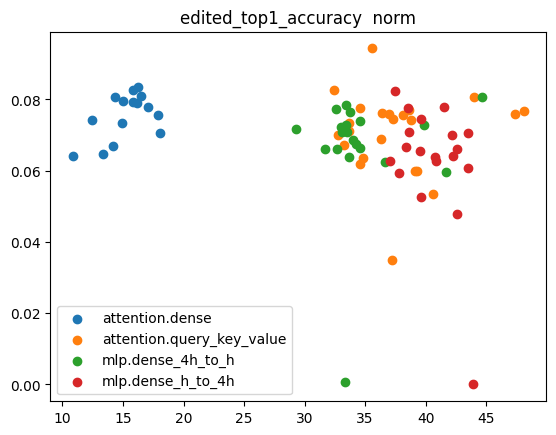

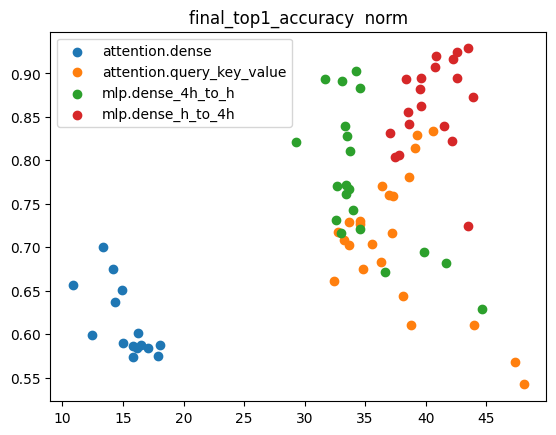

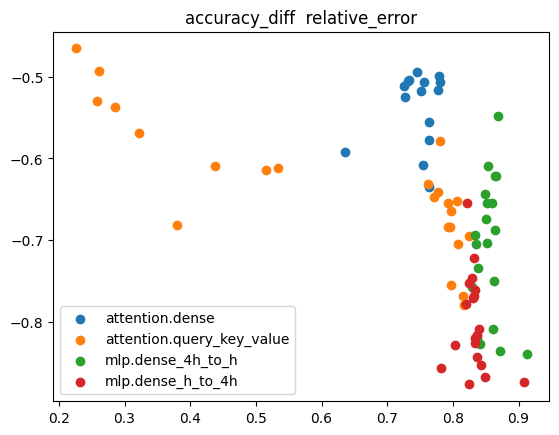

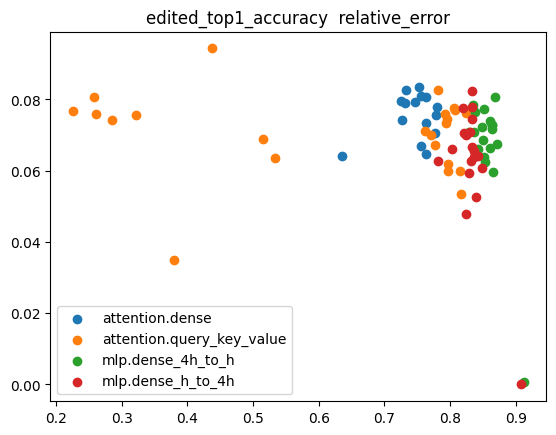

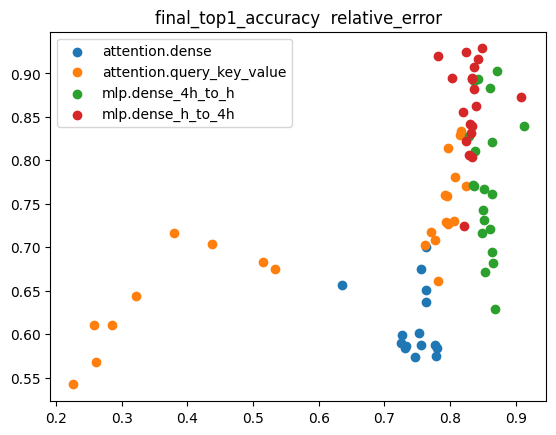

In [94]:
groups = df9.groupby('lname')

metrics = ["norm", "relative_error"]
outputs = ["accuracy_diff", "edited_top1_accuracy", "final_top1_accuracy"]





for m in metrics:
    for o in outputs:
        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.scatter(group[m], group[o], marker='o', label=name)
        ax.legend()
        plt.title(o + "  " + m)
        fig.savefig("outputs/plots/"+ o + "_vs_" + m + '.png')

        plt.show()

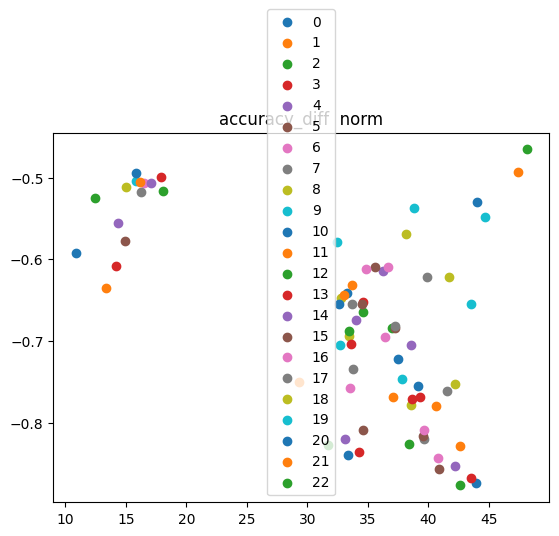

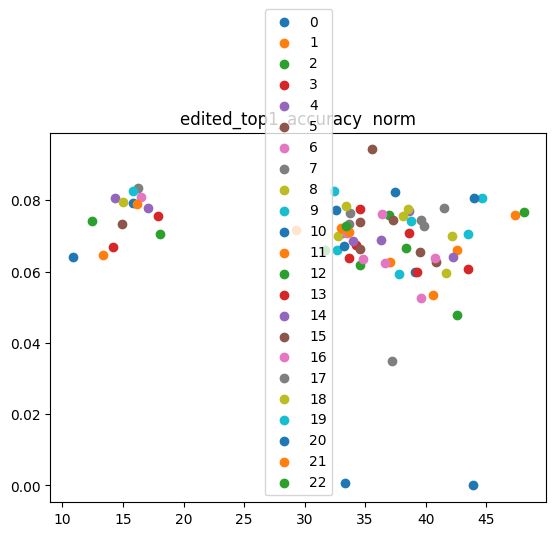

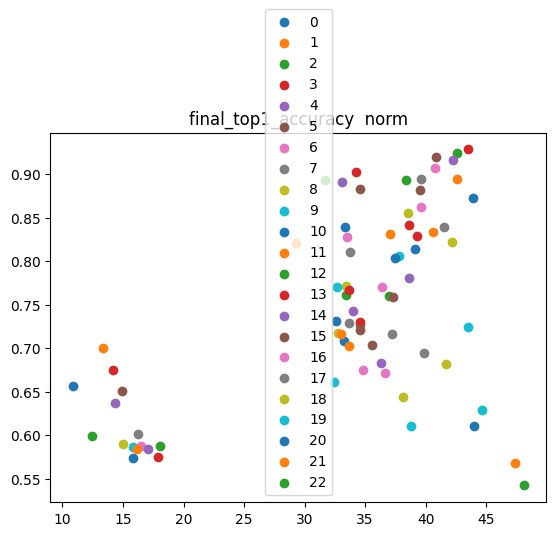

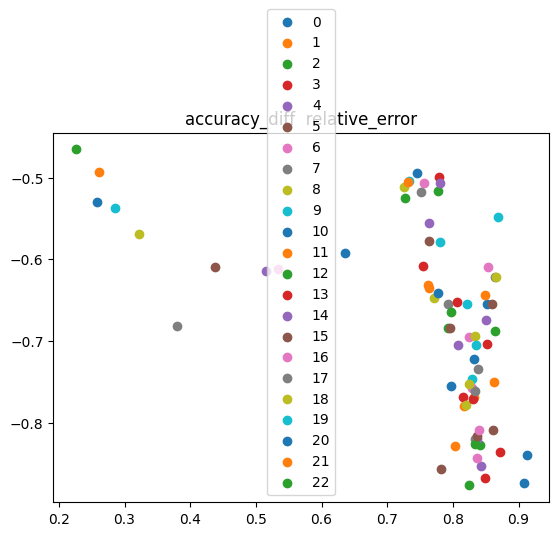

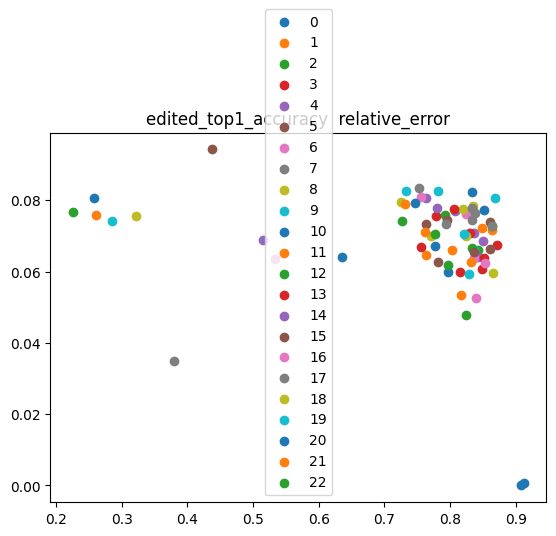

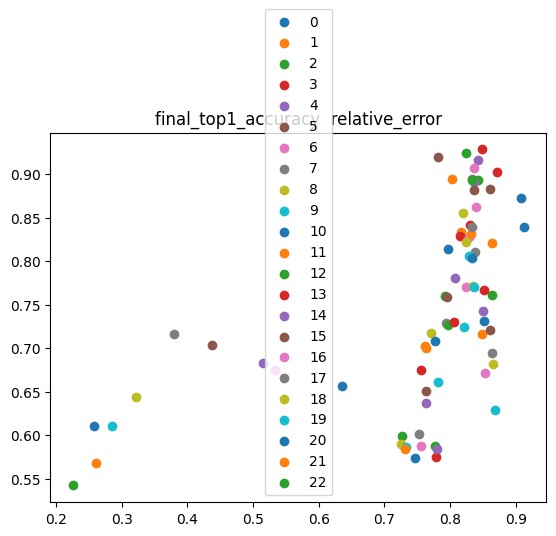

In [95]:
groups = df9.groupby('lnum')

metrics = ["norm", "relative_error"]
outputs = ["accuracy_diff", "edited_top1_accuracy", "final_top1_accuracy"]

for m in metrics:
    for o in outputs:
        # Plot
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.scatter(group[m], group[o], marker='o', label=name)
        ax.legend()
        plt.title(o + "  " + m)
        fig.savefig("outputs/plots/"+ o + "_vs_" + m + '.png')

        plt.show()

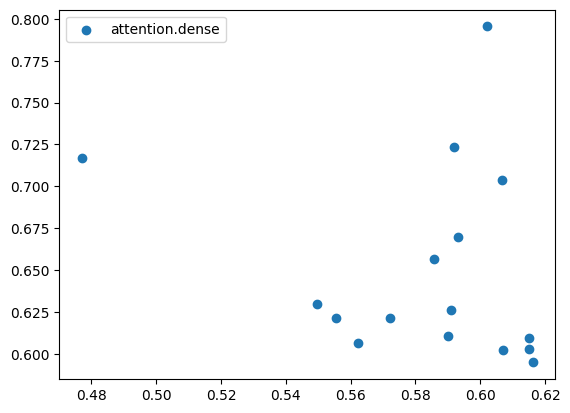

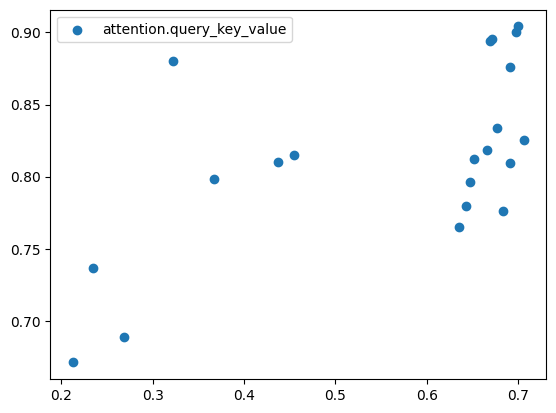

In [96]:
groups = df8.groupby('lname')


regressor = LinearRegression()

for name, group in groups:
    plt.scatter(group["relative_error"], group["final_top1_accuracy"], marker='o', label=name)
    plt.legend()
    plt.show()


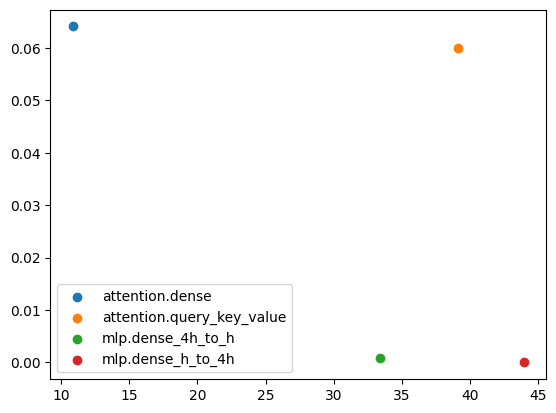

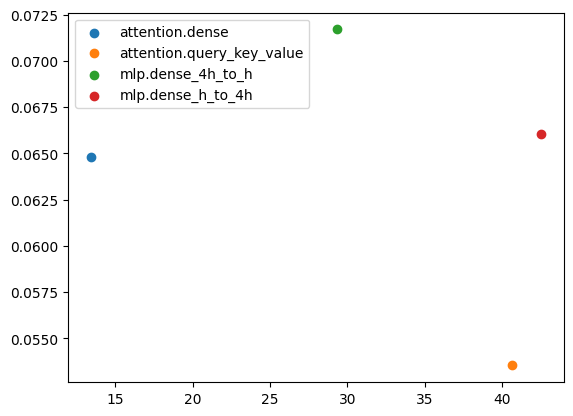

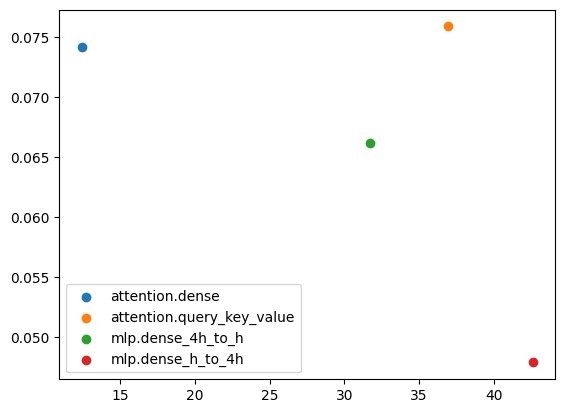

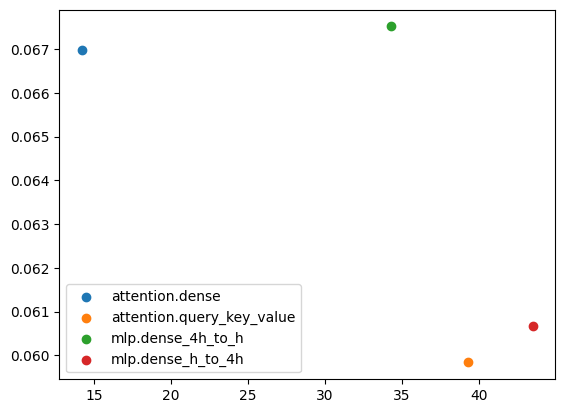

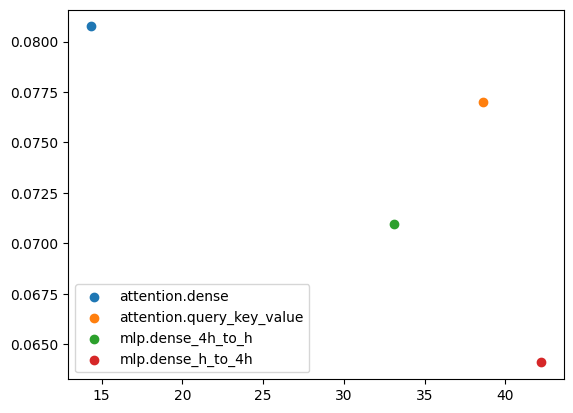

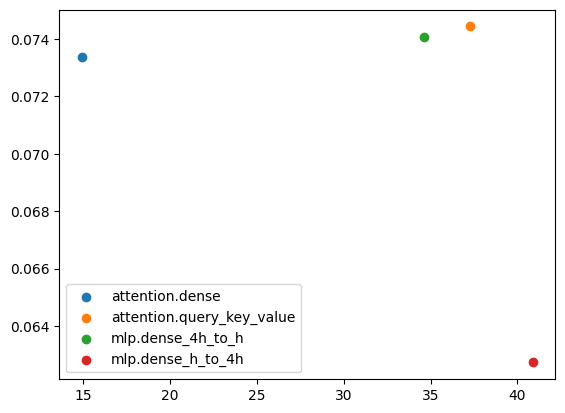

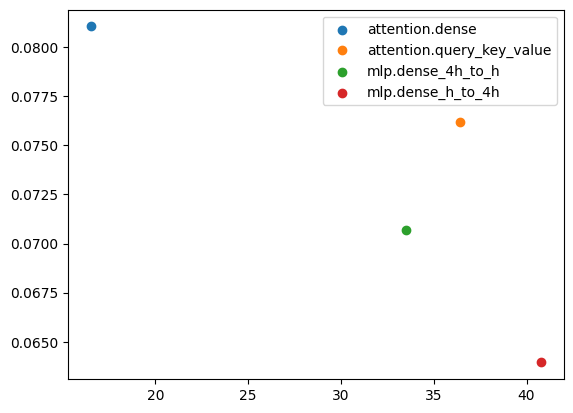

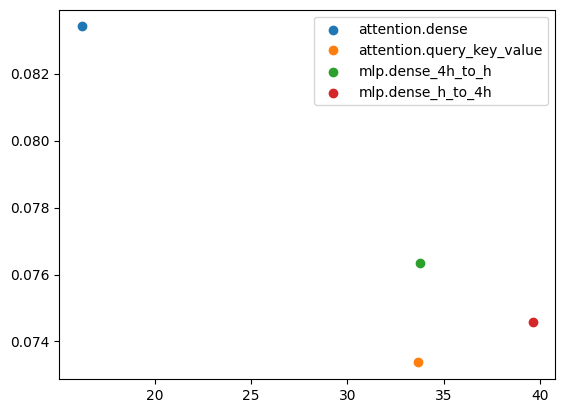

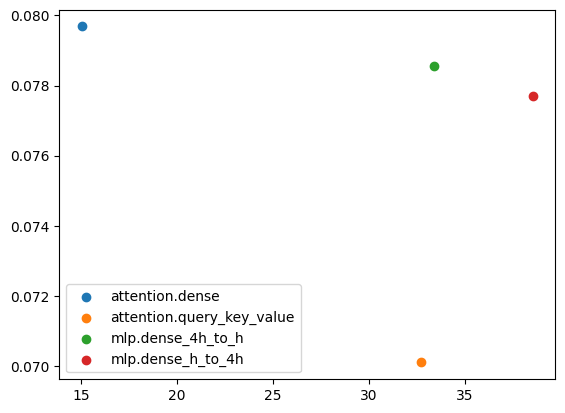

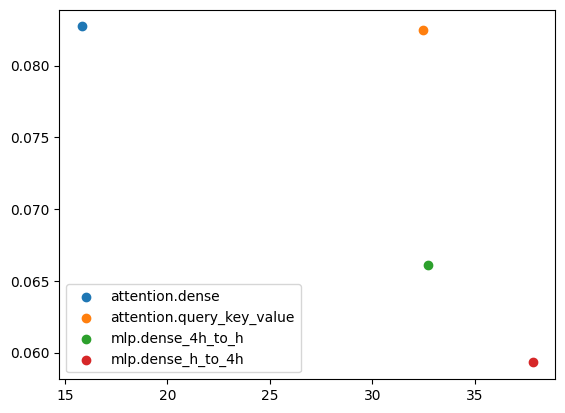

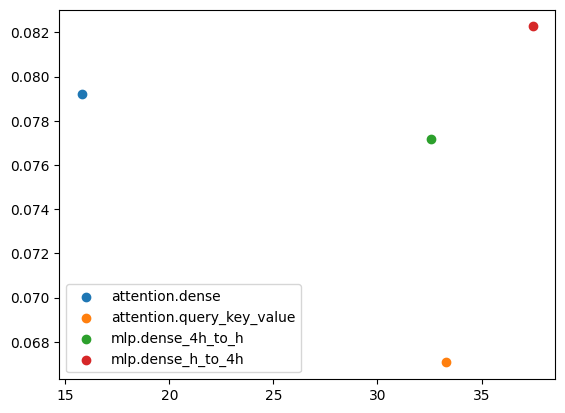

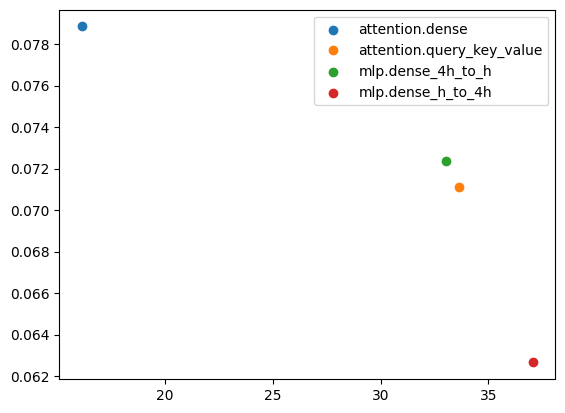

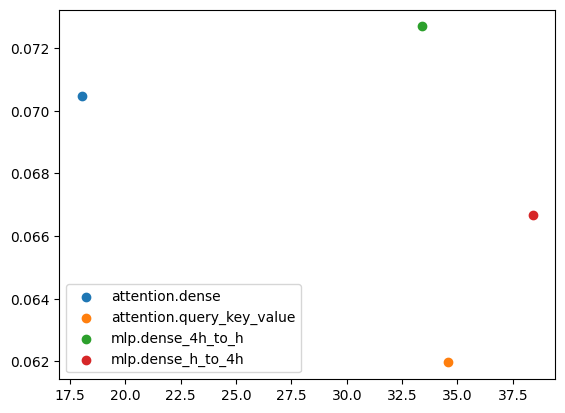

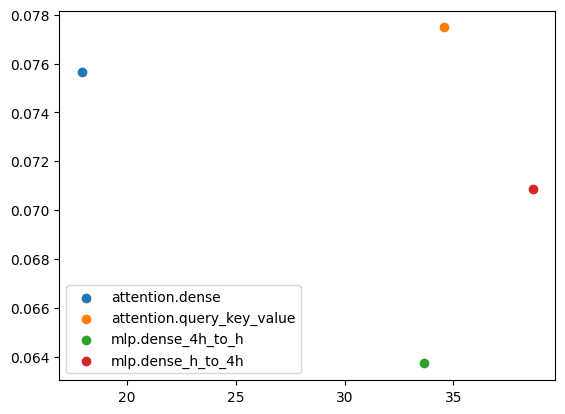

In [98]:
df_lnum0 = df[df["lnum"] == 0]

for l in range(14):
    df_lnum = df9[df9["lnum"] == l]
    groups = df_lnum.groupby('lname')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.scatter(group["norm"], group["edited_top1_accuracy"], marker='o', label=name)
        ax.legend()
    plt.show()


